In [1]:
import torch.nn as nn
import torch

In [37]:
import pickle
import pandas as pd
import numpy as np

file = open('/home/tom/work/rltensor/rltensor/app/ticker1.pkl', 'rb')
tickers = pickle.loads(file.read())
tickers = tickers[1:]
print(tickers)

closes = []
for ticker in tickers:
    df = pd.read_csv(f'../datasets/crypto/{ticker}.csv')
    df = df['close'].pct_change().dropna()
    # closes.append(df/ df.values[0])
    closes.append(df.values)
ret = np.stack(closes, axis=1)
ret[~np.isfinite(ret)] = 1.0

['USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_XMR', 'USDT_ZEC']


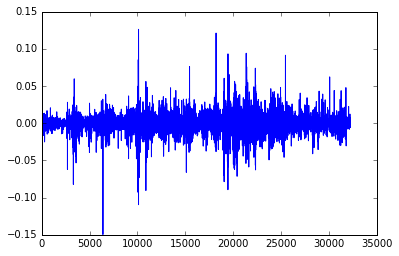

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(ret[:, 0])

In [39]:
ret

array([[ 7.81231242e-04,  1.84700860e-04, -1.22554867e-02, ...,
        -6.93566321e-03, -8.16382593e-03,  0.00000000e+00],
       [-1.54105274e-08, -9.16060287e-03, -1.05263157e-08, ...,
         7.25101408e-03, -5.99149056e-02,  0.00000000e+00],
       [-1.55960194e-03,  4.90460513e-03, -5.51900000e-03, ...,
        -7.67084496e-04,  8.41855469e-03,  0.00000000e+00],
       ...,
       [ 2.57458997e-03,  1.14147154e-02,  5.57029884e-03, ...,
         1.48445335e-03,  2.95038228e-02,  7.67202708e-03],
       [-3.05996223e-03,  4.56768484e-03, -5.23973847e-04, ...,
        -2.06634513e-03, -1.02078883e-02, -5.97019149e-03],
       [ 3.49355083e-03,  1.86935311e-03, -3.78180147e-03, ...,
         1.05175242e-02, -5.22487961e-03,  1.42358713e-02]])

In [44]:
class Emitter(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super(Emitter, self).__init__()
        self.lin1 = nn.Linear(z_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin_loc = nn.Linear(hidden_dim, input_dim)
        self.lin_scale = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        
    def forward(self, z_t):
        h1 = self.relu(self.lin1(z_t))
        h2 = self.relu(self.lin2(h1))
        loc = self.lin_loc(h2)
        scale = self.softplus(self.lin_scale(h2))
        return loc, scale
    
    
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(GatedTransition, self).__init__()
        # Transition layers
        self.lin_gate1 = nn.Linear(z_dim, hidden_dim)
        self.lin_gate2 = nn.Linear(hidden_dim, z_dim)
        # Non Linear estimation
        self.lin_prop_loc1 = nn.Linear(z_dim, hidden_dim)
        self.lin_prop_loc2 = nn.Linear(hidden_dim, z_dim)
        # Linear
        self.lin_lin_loc = nn.Linear(z_dim, z_dim)
        # Initilize parameters to make Identity mapping
        self.lin_lin_loc.weight.data = torch.eye(z_dim)
        self.lin_lin_loc.bias.data = torch.zeros(z_dim)
        # Scale
        self.lin_scale = nn.Linear(z_dim, z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z_t_1):
        _gate = self.relu(self.lin_gate1(z_t_1))
        gate = self.sigmoid(self.lin_gate2(_gate))
        _prop_loc = self.relu(self.lin_prop_loc1(z_t_1))
        prop_loc = self.lin_prop_loc2(_prop_loc)
        lin_loc = self.lin_lin_loc(z_t_1)
        loc = (1 - gate) * lin_loc + gate * prop_loc
        scale = self.softplus(self.lin_scale(z_t_1))
        return loc, scale

    
class Combiner(nn.Module):
    def __init__(self, z_dim, rnn_dim):
        super(Combiner, self).__init__()
        self.lin_zh = nn.Linear(z_dim, rnn_dim)
        self.lin_loc = nn.Linear(rnn_dim, z_dim)
        self.lin_scale = nn.Linear(rnn_dim, z_dim)
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()
        
    def forward(self, z_t_1, h_rnn):
        h_combined = 0.5 * (self.tanh(self.lin_zh(z_t_1)) + h_rnn)
        loc = self.lin_loc(h_combined)
        scale = self.softplus(self.lin_scale(h_combined))
        return loc, scale
    
import pyro
import pyro.distributions as dist

class DMM(nn.Module):
    def __init__(self, input_dim, z_dim=100, emission_dim=100,
                 transition_dim=200, rnn_dim=600, rnn_dropout_rate=0.0,
                 num_iafs=0, iaf_dim=50, use_cuda=False):
        super(DMM, self).__init__()
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, transition_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=rnn_dim,
                          nonlinearity='relu', batch_first=True,
                          bidirectional=False, num_layers=1,
                          dropout=rnn_dropout_rate)
        # Initial Parameters
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        
        self.use_cuda = use_cuda
        if use_cuda:
            self.cuda()
        
    def model(self, mini_batch, annealing_factor=1.0):
        T_max = mini_batch.size(1)
        pyro.module('dmm', self)
        z_prev = self.z_0.expand(mini_batch.size(0), self.z_0.size(0))
        
        with pyro.iarange('z_minibatch', len(mini_batch)):
            for t in range(1, T_max + 1):
                z_loc, z_scale = self.trans(z_prev)
                z_dist = dist.Normal(z_loc, z_scale)
                with pyro.poutine.scale(None, annealing_factor):
                    z_t = pyro.sample(f'z_{t}', z_dist.independent(1))
                em_loc, em_scale = self.emitter(z_t)
                obs_dist = dist.Normal(em_loc, em_scale)
                pyro.sample(f'obs_x_{t}',
                            obs_dist.independent(1),
                            obs=mini_batch[:, t-1, :])
                z_prev = z_t
                
    def guide(self, mini_batch, annealing_factor=1.0):
        T_max = mini_batch.size(1)
        pyro.module('dmm', self)
        h_0_contig = self.h_0.expand(1, mini_batch.size(0),
                                     self.rnn.hidden_size).contiguous()
        rnn_output, _ = self.rnn(mini_batch, h_0_contig)
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))
        with pyro.iarange('z_minibatch', len(mini_batch)):
            for t in range(1, T_max + 1):
                z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t-1, :])
                z_dist = dist.Normal(z_loc, z_scale)
                with pyro.poutine.scale(None, annealing_factor):
                    z_t = pyro.sample(f'z_{t}', z_dist.independent(1))
                z_prev = z_t

In [45]:
import torch
import torch.utils.data as tdata
import numpy as np


class TimeSeriesDataset(tdata.Dataset):
    '''Subclass of torch.utils.data.Dataset from numpy array for time series data
    X; array-like
    y: array-like, optional
    '''
    def __init__(self, X, y=None, timelag=10):
        self.X = torch.tensor(X).float()
        if y is not None:
            if np.issubdtype(y.dtype, np.integer):
                y = torch.tensor(y).long()
            else:
                y = torch.tensor(y).float()
        self.y = y
        self.timelag = timelag

    def __len__(self):
        return len(self.X) - (self.timelag - 1)

    def __getitem__(self, index):
        if self.y is None:
            return self.X[index: index + self.timelag]
        else:
            return self.X[index: index + self.timelag], self.y[index: index + self.timelag]

In [50]:
from pyro.optim import Adam
from pyro.infer import Trace_ELBO, SVI

from tqdm import tqdm_notebook

input_dim = ret.shape[-1]
z_dim = 10
emission_dim = 10
transition_dim = 10
rnn_dim = 10
rnn_dropout_rate = .2
timelag = 100

pyro.clear_param_store()
dmm = DMM(input_dim, z_dim, emission_dim, transition_dim,
          rnn_dim, rnn_dropout_rate)
adam_params = {"lr": 1e-3}
optimizer = Adam(adam_params)

svi = SVI(dmm.model, dmm.guide, optimizer, Trace_ELBO())

data = TimeSeriesDataset(X=ret[:1000], timelag=timelag)
train_loader = tdata.DataLoader(data, batch_size=32, shuffle=True)
for i in tqdm_notebook(range(20)):
    losses = []
    for X in train_loader:
        loss = svi.step(X)
        losses.append(loss)
    print(np.mean(losses))

/home/tom/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

19330.201992495306
15078.944713460987
8874.992663146093
-10101.609323303248
-36661.8068651002
-53063.362666253386
-56317.4532064405
-61267.281891541235
-62388.337074329116
-63736.17713758863
-64406.88253053098
-64974.01975128568
-64601.233851778095
-64896.26435831909
-65438.82268581514
-65782.40056028448
-65935.74847604283
-65023.9919457004
-65786.17373125101
-66147.47338572863


In [34]:
help(tdata.DataLoader)

Help on class DataLoader in module torch.utils.data.dataloader:

class DataLoader(builtins.object)
 |  Data loader. Combines a dataset and a sampler, and provides
 |  single- or multi-process iterators over the dataset.
 |  
 |  Arguments:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: 1).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: False).
 |      sampler (Sampler, optional): defines the strategy to draw samples from
 |          the dataset. If specified, ``shuffle`` must be False.
 |      batch_sampler (Sampler, optional): like sampler, but returns a batch of
 |          indices at a time. Mutually exclusive with batch_size, shuffle,
 |          sampler, and drop_last.
 |      num_workers (int, optional): how many subprocesses to use for data
 |          loading. 0 means that the data will be loaded in the